In [0]:
# visualization library
import cv2
import PIL
from matplotlib import pyplot as plt
# data storing library
import numpy as np
import pandas as pd
# torch libraries
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
# architecture and data split library
from sklearn.model_selection import train_test_split
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp
# augmenation library
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor
# others
import os
import pdb
import time
import warnings
import random
from tqdm import tqdm_notebook as tqdm
import concurrent.futures
# warning print supression
warnings.filterwarnings("ignore")

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
from google.colab import drive

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('/content/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
# list of files in Google Drive folder
file_list = drive.ListFile(
    {'q': "'1MsgfnmWPV-Nod0s1ZejYfsvbIwRMKZg_' in parents"}).GetList()

# find data in .zip format and save it
for f in file_list:
  # read csv file with predictions from previous layer (probability for each 
  #image whether there are any defect on it)
  if f['title'] == "classes_probabilities.csv":
    fname = os.path.join(local_download_path, f['title'])
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)

  if f['title'] == "severstal-steel-defect-detection.zip":
    zipname = os.path.join(local_download_path, f['title'])
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(zipname)

    # extract files from zip to "extracted/" directory, this directory will be 
    # used for further data modelling
    zip_ref = zipfile.ZipFile(zipname, 'r')
    zip_ref.extractall(os.path.join(local_download_path, "extracted"))
    zip_ref.close()


In [0]:
working_dir = os.path.join(local_download_path, "extracted")

# defining working folders and labels
train_images_folder = os.path.join(working_dir, "train_images")
train_labels_file = os.path.join(working_dir, "train.csv")

test_images_folder = os.path.join(working_dir, "test_images")
test_labels_file = os.path.join(working_dir, "sample_submission.csv")

In [0]:
train_labels = pd.read_csv(train_labels_file)
test_labels = pd.read_csv(test_labels_file)

In [0]:
probabilities = pd.read_csv(fname).drop(["Unnamed: 0"], axis=1)

In [0]:
class_1_df = pd.DataFrame()
class_2_df = pd.DataFrame()
class_3_df = pd.DataFrame()
class_4_df = pd.DataFrame()

selected_class_1 = probabilities.ImageId[probabilities.Class_1 > 0.5].to_list()
selected_class_2 = probabilities.ImageId[probabilities.Class_2 > 0.5].to_list()
selected_class_3 = probabilities.ImageId[probabilities.Class_3 > 0.5].to_list()
selected_class_4 = probabilities.ImageId[probabilities.Class_4 > 0.5].to_list()

for index, row in test_labels.iterrows():
  
  if row.ImageId in selected_class_1:
    class_1_df = class_1_df.append(row, ignore_index=True)
  
  if row.ImageId in selected_class_2:
    class_2_df = class_2_df.append(row, ignore_index=True)

  if row.ImageId in selected_class_3:
    class_3_df = class_3_df.append(row, ignore_index=True)

  if row.ImageId in selected_class_4:
    class_4_df = class_4_df.append(row, ignore_index=True)

In [0]:
train4class_1 = train_labels[train_labels.ClassId == 1]
train4class_2 = train_labels[train_labels.ClassId == 2]
train4class_3 = train_labels[train_labels.ClassId == 3]
train4class_4 = train_labels[train_labels.ClassId == 4]

In [0]:
!mkdir data/train_classes/class_1/ -p
!mkdir data/train_classes/class_2/ -p
!mkdir data/train_classes/class_3/ -p
!mkdir data/train_classes/class_4/ -p

train_classes_folder = "/content/data/train_classes"

In [0]:
from shutil import copyfile

def copy_class2folder(df, source_path, target_path ):
  for filename in df.ImageId:
    PIL.Image.open(os.path.join(source_path, filename)).resize((256, 256)).save(os.path.join(target_path, filename.split(".")[0] + ".png"))

In [0]:
copy_class2folder(train4class_1, train_images_folder,  os.path.join(train_classes_folder, "class_1/"))
copy_class2folder(train4class_2, train_images_folder,  os.path.join(train_classes_folder, "class_2/"))
copy_class2folder(train4class_3, train_images_folder,  os.path.join(train_classes_folder, "class_3/"))
copy_class2folder(train4class_4, train_images_folder,  os.path.join(train_classes_folder, "class_4/"))

In [0]:
train4class_1.ImageId = train4class_1.ImageId.str.replace("jpg", "png")
train4class_2.ImageId = train4class_2.ImageId.str.replace("jpg", "png")
train4class_3.ImageId = train4class_3.ImageId.str.replace("jpg", "png")
train4class_4.ImageId = train4class_4.ImageId.str.replace("jpg", "png")

In [0]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(shape).T

In [0]:
def rle2img(rle, path):
  mask = rle_decode(rle, (1600, 256))
  image = PIL.Image.fromarray(mask).resize((256, 256))
  image.save(path)

In [0]:
def encoded_px2images(path, df):
  for index, row in df.iterrows():
    rle = row.EncodedPixels
    imagename = row.ImageId.split(".")[0]
    
    rle2img(rle, os.path.join(path, imagename + ".png"))

In [0]:
!mkdir data/train_masks/class_1/ -p
!mkdir data/train_masks/class_2/ -p
!mkdir data/train_masks/class_3/ -p
!mkdir data/train_masks/class_4/ -p 

train_masks_folder = "/content/data/train_masks"

In [0]:
encoded_px2images(os.path.join(train_masks_folder, "class_1"), train4class_1)
encoded_px2images(os.path.join(train_masks_folder, "class_2"), train4class_2)
encoded_px2images(os.path.join(train_masks_folder, "class_3"), train4class_3)
encoded_px2images(os.path.join(train_masks_folder, "class_4"), train4class_4)

In [0]:
# imagenet mean/std will be used as the resnet backbone is trained on imagenet stats
mean, std=(0.485, 0.456, 0.406),(0.229, 0.224, 0.225)

# during traning/val phase make a list of transforms to be used.
# input-->"phase",mean,std
# output-->list
def get_transform(phase,mean,std):
    list_trans=[]
    if phase=='train':
        list_trans.extend([HorizontalFlip(p=0.5)])
    list_trans.extend([Normalize(mean=mean,std=std, p=1), ToTensor()])  #normalizing the data & then converting to tensors
    list_trans=Compose(list_trans)
    return list_trans

In [0]:
'''when dataloader request for samples using index it fetches input image and target mask,
apply transformation and returns it'''
class SteelDataset(Dataset):
    
    def __init__(self,df,img_fol,mask_fol,mean,std,phase):
        self.fname=df['ImageId'].values.tolist()
        self.img_fol=img_fol
        self.mask_fol=mask_fol
        self.mean=mean
        self.std=std
        self.phase=phase
        self.trasnform=get_transform(phase,mean,std)
    
    def __getitem__(self, idx):
        name=self.fname[idx]
        img_name_path=os.path.join(self.img_fol,name)
        mask_name_path=os.path.join(self.mask_fol,name)
        img=cv2.imread(img_name_path)
        mask=cv2.imread(mask_name_path,cv2.IMREAD_GRAYSCALE)
        augmentation=self.trasnform(image=img, mask=mask)
        img_aug=augmentation['image']                           #[3,128,128] type:Tensor
        mask_aug=augmentation['mask']                           #[1,128,128] type:Tensor
        return img_aug, mask_aug

    def __len__(self):
        return len(self.fname)

In [0]:
'''divide data into train and val and return the dataloader depending upon train or val phase.'''
def SteelDataloader(df,img_fol,mask_fol,mean,std,phase,batch_size,num_workers):
    df_train,df_valid=train_test_split(df, test_size=0.2, random_state=69)
    df = df_train if phase=='train' else df_valid
    for_loader=SteelDataset(df, img_fol, mask_fol, mean, std, phase)
    dataloader=DataLoader(for_loader, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

    return dataloader

In [0]:
'''calculates dice scores when Scores class for it'''
def dice_score(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

''' initialize a empty list when Scores is called, append the list with dice scores
for every batch, at the end of epoch calculates mean of the dice scores'''
class Scores:
    def __init__(self, phase, epoch):
        self.base_dice_scores = []

    def update(self, targets, outputs):
        probs = outputs
        dice= dice_score(probs, targets)
        self.base_dice_scores.append(dice)

    def get_metrics(self):
        dice = np.mean(self.base_dice_scores)         
        return dice

'''return dice score for epoch when called'''
def epoch_log(epoch_loss, measure):
    '''logging the metrics at the end of an epoch'''
    dices= measure.get_metrics()    
    dice= dices                       
    print("Loss: %0.4f |dice: %0.4f" % (epoch_loss, dice))
    return dice

In [0]:
class Trainer(object):
    def __init__(self,model):
        self.num_workers=4
        self.batch_size={'train':1, 'val':1}
        self.accumulation_steps=4//self.batch_size['train']
        self.lr=5e-4
        self.num_epochs=15
        self.phases=['train','val']
        self.best_loss=float('inf')
        self.device=torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net=model.to(self.device)
        cudnn.benchmark= True
        self.criterion=torch.nn.BCEWithLogitsLoss()
        self.optimizer=optim.Adam(self.net.parameters(),lr=self.lr)
        self.scheduler=ReduceLROnPlateau(self.optimizer,mode='min',patience=3, verbose=True)
        self.dataloaders={phase: SteelDataloader(train4class_1, os.path.join(train_classes_folder, "class_1/"),
                                               os.path.join(train_masks_folder, "class_1/"), mean, std,
                                               phase=phase,batch_size=self.batch_size[phase],
                                               num_workers=self.num_workers) for phase in self.phases}

        self.losses={phase:[] for phase in self.phases}
        self.dice_score={phase:[] for phase in self.phases}

    def forward(self, inp_images, tar_mask):
        inp_images=inp_images.to(self.device)
        tar_mask=tar_mask.to(self.device)
        pred_mask=self.net(inp_images)
        loss=self.criterion(pred_mask,tar_mask)
        return loss, pred_mask

    def iterate(self, epoch, phase):
        measure=Scores(phase, epoch)
        start=time.strftime("%H:%M:%S")
        print (f"Starting epoch: {epoch} | phase:{phase} | 🙊':{start}")
        batch_size=self.batch_size[phase]
        self.net.train(phase=="train")
        dataloader=self.dataloaders[phase]
        running_loss=0.0
        total_batches=len(dataloader)
        self.optimizer.zero_grad()
        for itr,batch in enumerate(dataloader):
            images,mask_target=batch
            loss, pred_mask=self.forward(images,mask_target)
            loss=loss/self.accumulation_steps
            if phase=='train':
                loss.backward()
                if (itr+1) % self.accumulation_steps ==0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss+=loss.item()
            pred_mask=pred_mask.detach().cpu()
            measure.update(mask_target,pred_mask)
        epoch_loss=(running_loss*self.accumulation_steps)/total_batches
        dice=epoch_log(epoch_loss, measure)
        self.losses[phase].append(epoch_loss)
        self.dice_score[phase].append(dice)
        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range (self.num_epochs):
            self.iterate(epoch,"train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            with torch.no_grad():
                val_loss=self.iterate(epoch,"val")
                self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./model_office.pth")
            print ()

In [22]:
model = smp.Unet("resnet18", encoder_weights="imagenet", classes=1, activation=None)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 39.7MB/s]


In [23]:
model_trainer = Trainer(model)
model_trainer.start()

Starting epoch: 0 | phase:train | 🙊':19:30:36
Loss: 0.1065 |dice: 0.0000
Starting epoch: 0 | phase:val | 🙊':19:30:54
Loss: 0.0200 |dice: 0.0000
******** New optimal found, saving state ********

Starting epoch: 1 | phase:train | 🙊':19:30:56
Loss: 0.0114 |dice: 0.0000
Starting epoch: 1 | phase:val | 🙊':19:31:13
Loss: 0.0067 |dice: 0.0000
******** New optimal found, saving state ********

Starting epoch: 2 | phase:train | 🙊':19:31:15
Loss: 0.0047 |dice: 0.0000
Starting epoch: 2 | phase:val | 🙊':19:31:31
Loss: 0.0035 |dice: 0.0000
******** New optimal found, saving state ********

Starting epoch: 3 | phase:train | 🙊':19:31:34
Loss: 0.0027 |dice: 0.0000
Starting epoch: 3 | phase:val | 🙊':19:31:50
Loss: 0.0022 |dice: 0.0000
******** New optimal found, saving state ********

Starting epoch: 4 | phase:train | 🙊':19:31:52
Loss: 0.0019 |dice: 0.0000
Starting epoch: 4 | phase:val | 🙊':19:32:09
Loss: 0.0016 |dice: 0.0000
******** New optimal found, saving state ********

Starting epoch: 5 | phase

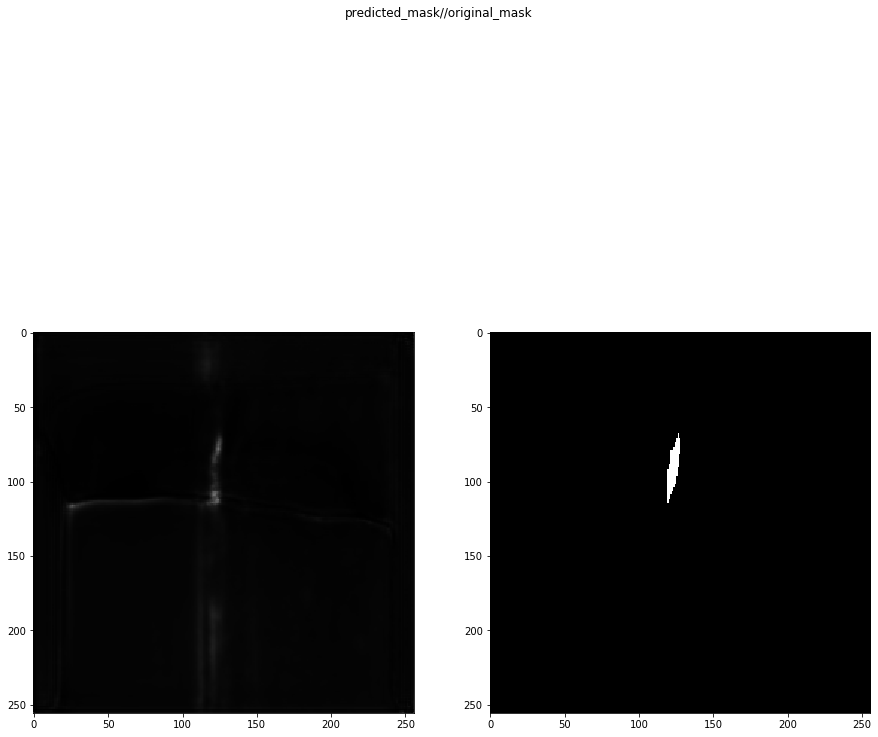

In [40]:
test_dataloader=SteelDataloader(train4class_1, os.path.join(train_classes_folder, "class_1"), os.path.join(train_masks_folder, "class_1") ,mean,std,'val',1,4)

ckpt_path='model_office.pth'

device = torch.device("cuda")
model = smp.Unet("resnet18", encoder_weights=None, classes=1, activation=None)
model.to(device)
model.eval()
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])

# start prediction
predictions = []
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,15))
fig.suptitle('predicted_mask//original_mask')
for i, batch in enumerate(tqdm(test_dataloader)):
    images,mask_target = batch
    batch_preds = torch.sigmoid(model(images.to(device)))
    batch_preds = batch_preds.detach().cpu().numpy()
    ax1.imshow(np.squeeze(batch_preds),cmap='gray')
    ax2.imshow(np.squeeze(mask_target),cmap='gray')
    break